In [1]:
import numpy as np
import pandas as pd
import json
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
import keras
from keras.layers import Input, Bidirectional, LSTM, Embedding, Dense, Dropout, Conv1D, MaxPooling1D, Flatten, TextVectorization
from keras.models import Model, Sequential
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sn
import matplotlib.pyplot as plt

nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
!pip install demoji
import demoji

[nltk_data] Downloading package wordnet to /home/anz007/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/anz007/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/anz007/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Preprocessing

#### Load Data

In [2]:
pd.set_option("display.max_colwidth", None)
data = pd.read_csv("data/tweets_labelled.csv")
data.head(10)

,tweet,polaritas,sentimen
0,jbharga ayam rm tgk telor wyam sepapan rm depend gred,-2,Negatif
1,berdiri di atas kaki sendiri serap telur peternak stabilkan harga,-2,Negatif
2,penyebab harga telur anjlok versi pedagang kaget,-1,Negatif
3,turunnya permintaan masyarakat telur ayam ppkm level jawa bali harga telur ayam daerah jawa bali anjlok rupiah kilogramnyapara peternak ayam petelur mengeluhkan gulung tikar,-1,Negatif
4,peternak ayam petelur mengaku merugi ratusan juta rupiah bulannya harga pakan ayam petelur pasarananjloknya harga jual telur ayam situasi ppkm menyebabkan turunnya permintaan,1,Positif
5,harga jual telur ayam solo raya anjlok iniharga eceran telur ayam negeri pasar tradisional warung berandol rp kilogramnyatentu rumah tangga pengusaha kuliner berbahan dasar telur ayam kegirangan,-5,Negatif
6,harga telur anjlok rp kg pemerintah bantu peternak ayam,-2,Negatif
7,ikutan main telur bareng voucher potongan harga belanja hhe,15,Positif
8,telor geprek abah uya selera bohong harga murmer,4,Positif
9,beli order telur set telur mcd scam bayar harga set telur set pulak mengandung kecewa,1,Positif


#### Convert Label to Integer

In [3]:
data['sentimen'] = data['sentimen'].astype('category').cat.codes
data.head()

,tweet,polaritas,sentimen
0,jbharga ayam rm tgk telor wyam sepapan rm depend gred,-2,0
1,berdiri di atas kaki sendiri serap telur peternak stabilkan harga,-2,0
2,penyebab harga telur anjlok versi pedagang kaget,-1,0
3,turunnya permintaan masyarakat telur ayam ppkm level jawa bali harga telur ayam daerah jawa bali anjlok rupiah kilogramnyapara peternak ayam petelur mengeluhkan gulung tikar,-1,0
4,peternak ayam petelur mengaku merugi ratusan juta rupiah bulannya harga pakan ayam petelur pasarananjloknya harga jual telur ayam situasi ppkm menyebabkan turunnya permintaan,1,1


#### Split Data to Train and Test

In [4]:
X = data['tweet']
y = data['sentimen']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.1, stratify=y)

#### Convert Word to Integer (Index) and Label to One Hot Encoding

In [5]:
vectorizer = TextVectorization(max_tokens=20000, output_sequence_length=200)
vectorizer.adapt(X_train)
voc = len(vectorizer.get_vocabulary())

2021-12-12 13:34:43.146604: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-12 13:34:43.191351: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-12 13:34:43.191504: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-12 13:34:43.192112: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [6]:
train_seq = vectorizer(X_train)
train_seq[:3]

<tf.Tensor: shape=(3, 200), dtype=int64, numpy=
array([[ 114,    2,    6,    4,   83,   15, 5797,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,   

In [7]:
y_seq = to_categorical(y_train, num_classes = 3)
y_seq[:3]

array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.]], dtype=float32)

### Modeling

#### ANN

In [8]:
ann = Sequential()
ann.add(Embedding(voc, 50, input_length=200))
ann.add(Dense(10, activation='relu'))
ann.add(Dropout(0.2))
ann.add(Dense(5, activation='relu'))
ann.add(Flatten())
ann.add(Dense(3, activation='softmax'))
ann.compile(loss='mean_squared_error', optimizer='adam')
ann.summary()

ann.fit(train_seq, y_seq, epochs=10, batch_size=50, shuffle=False)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 50)           339300    
                                                                 
 dense (Dense)               (None, 200, 10)           510       
                                                                 
 dropout (Dropout)           (None, 200, 10)           0         
                                                                 
 dense_1 (Dense)             (None, 200, 5)            55        
                                                                 
 flatten (Flatten)           (None, 1000)              0         
                                                                 
 dense_2 (Dense)             (None, 3)                 3003      
                                                                 
Total params: 342,868
Trainable params: 342,868
Non-trai

2021-12-12 13:34:49.614161: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


52/52 [==============================] - 0s 2ms/step - loss: 0.0963
Epoch 4/10
52/52 [==============================] - 0s 2ms/step - loss: 0.0652
Epoch 5/10
52/52 [==============================] - 0s 2ms/step - loss: 0.0455
Epoch 6/10
52/52 [==============================] - 0s 2ms/step - loss: 0.0353
Epoch 7/10
52/52 [==============================] - 0s 2ms/step - loss: 0.0291
Epoch 8/10
52/52 [==============================] - 0s 2ms/step - loss: 0.0247
Epoch 9/10
52/52 [==============================] - 0s 2ms/step - loss: 0.0195
Epoch 10/10
52/52 [==============================] - 0s 2ms/step - loss: 0.0166


#### CNN

In [9]:
cnn = Sequential()
cnn.add(Embedding(voc, 50, input_length=200))
cnn.add(Conv1D(32, kernel_size=5, activation='relu'))
cnn.add(MaxPooling1D(pool_size=2))
cnn.add(Conv1D(64, kernel_size=5, activation='relu'))
cnn.add(MaxPooling1D(pool_size=2))
cnn.add(Flatten())
cnn.add(Dense(10, activation='relu'))
cnn.add(Dropout(0.2))
cnn.add(Dense(3, activation='softmax'))
cnn.compile(loss='mean_squared_error', optimizer='adam')
cnn.summary()

cnn.fit(train_seq, y_seq, epochs=10, batch_size=50, shuffle=False)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 200, 50)           339300    
                                                                 
 conv1d (Conv1D)             (None, 196, 32)           8032      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 98, 32)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 94, 64)            10304     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 47, 64)           0         
 1D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 3008)             

2021-12-12 13:34:51.366547: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8204


52/52 [==============================] - 2s 7ms/step - loss: 0.1506
Epoch 2/10
52/52 [==============================] - 0s 2ms/step - loss: 0.1097
Epoch 3/10
52/52 [==============================] - 0s 2ms/step - loss: 0.0576
Epoch 4/10
52/52 [==============================] - 0s 2ms/step - loss: 0.0358
Epoch 5/10
52/52 [==============================] - 0s 2ms/step - loss: 0.0242
Epoch 6/10
52/52 [==============================] - 0s 2ms/step - loss: 0.0211
Epoch 7/10
52/52 [==============================] - 0s 2ms/step - loss: 0.0177
Epoch 8/10
52/52 [==============================] - 0s 2ms/step - loss: 0.0143
Epoch 9/10
52/52 [==============================] - 0s 2ms/step - loss: 0.0159
Epoch 10/10
52/52 [==============================] - 0s 2ms/step - loss: 0.0150


#### LSTM

In [10]:
lstm = Sequential()
lstm.add(Embedding(voc, 50, input_length=200))
lstm.add(LSTM(10, return_sequences=True))
lstm.add(LSTM(5))
lstm.add(Dropout(0.2))
lstm.add(Dense(5))
lstm.add(Dense(3, activation="softmax"))
lstm.summary()
lstm.compile('rmsprop','mse')

lstm.fit(train_seq, y_seq, epochs=10, batch_size=50, shuffle=False)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 200, 50)           339300    
                                                                 
 lstm (LSTM)                 (None, 200, 10)           2440      
                                                                 
 lstm_1 (LSTM)               (None, 5)                 320       
                                                                 
 dropout_2 (Dropout)         (None, 5)                 0         
                                                                 
 dense_5 (Dense)             (None, 5)                 30        
                                                                 
 dense_6 (Dense)             (None, 3)                 18        
                                                                 
Total params: 342,108
Trainable params: 342,108
Non-tr

#### BiLSTM

In [11]:
blstm = Sequential()
blstm.add(Embedding(voc, 50, input_length=200))
blstm.add(Bidirectional(LSTM(10, return_sequences=True)))
blstm.add(Bidirectional(LSTM(5)))
blstm.add(Dropout(0.2))
blstm.add(Dense(5))
blstm.add(Dense(3, activation="softmax"))
blstm.summary()
blstm.compile('rmsprop','mse')

blstm.fit(train_seq, y_seq, epochs=10, batch_size=50, shuffle=False)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 200, 50)           339300    
                                                                 
 bidirectional (Bidirectiona  (None, 200, 20)          4880      
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 10)               1040      
 nal)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 10)                0         
                                                                 
 dense_7 (Dense)             (None, 5)                 55        
                                                                 
 dense_8 (Dense)             (None, 3)                

### Evaluation

In [12]:
def plot_matrix(y_test, y_pred):
  cnf_matrix = confusion_matrix(y_test, y_pred)
  index = ["negative", "positive"]
  columns = ["negative", "positive"]
  df_cm = pd.DataFrame(cnf_matrix,columns,index)

  sn.heatmap(df_cm, annot=True, cmap=plt.cm.Blues, fmt=".0f", annot_kws={"size": 10}) # font size
  plt.xlabel("Predicted label", fontsize = 10)
  plt.ylabel("True label", fontsize = 10)

  plt.show()

In [13]:
def false_cases(sentences, y_test, y_pred):
  df = pd.DataFrame(list(zip(sentences, y_test, y_pred)), columns=["sentence", "label", "prediction"])
  df = df[df['label'] != df['prediction']]
  return df


#### Convert Word to Integer (Index)

In [14]:
test_seq = vectorizer(np.array(X_test))

In [15]:
target_names = ["negative", "positive"]

#### ANN

In [16]:
y_pred = ann.predict(test_seq, verbose=0)
y_pred = np.argmax(y_pred, axis=1)

In [17]:
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

    negative       0.58      0.53      0.56        73
    positive       0.85      0.87      0.86       215

    accuracy                           0.78       288
   macro avg       0.71      0.70      0.71       288
weighted avg       0.78      0.78      0.78       288



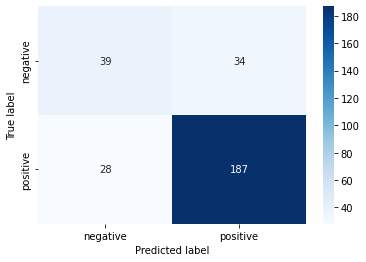

In [18]:
plot_matrix(y_test, y_pred)

In [19]:
pred_result = false_cases(X_test, y_test, y_pred)
pred_result

,sentence,label,prediction
2,sedih banget sebulan jualan telur ayam tipis banget untungnya harga pasaran anjlok semoga berita,0,1
3,tv kmrin harga telor anjlok perusahaan ayam petelor,1,0
5,kemarin jokowi bantu peternak beli telor telorkan turun jokowi disuruh beli jagung harga wajar emang jkw pedagang,1,0
10,maghrib berburu telur harga telur kg kedepan telur telur telur,0,1
12,harga pakan meroket telur ambruk peternak garut terpaksa lelang ayam,0,1
...,...,...,...
263,pasar sederhana harga beras medium rpkg gula pasir rpkg daging ayam ras rpkg daging sapi rpkg telur ayam ras rpkg cabai merah keriting rpkg bawang putih kating rpkg,0,1
276,sehari rp juta harga telur anjlok peternak berpotensi rugi puluhan juta rupiah,1,0
277,harga telor turun banget plis ayah ambil dijual toko what the fuck seperempat ribu ratus what the fuck kobisa turun segitu,0,1
278,harga telur ayam turun rp kilogramnya,1,0


#### CNN

In [20]:
y_pred = cnn.predict(test_seq, verbose=0)
y_pred = np.argmax(y_pred, axis=1)

In [21]:
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

    negative       0.80      0.56      0.66        73
    positive       0.86      0.95      0.91       215

    accuracy                           0.85       288
   macro avg       0.83      0.76      0.78       288
weighted avg       0.85      0.85      0.84       288



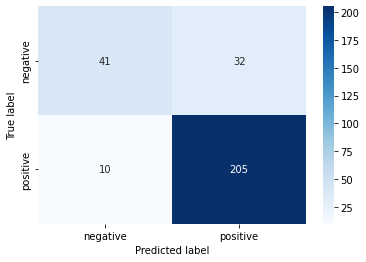

In [22]:
plot_matrix(y_test, y_pred)

In [23]:
pred_result = false_cases(X_test, y_test, y_pred)
pred_result

,sentence,label,prediction
2,sedih banget sebulan jualan telur ayam tipis banget untungnya harga pasaran anjlok semoga berita,0,1
3,tv kmrin harga telor anjlok perusahaan ayam petelor,1,0
10,maghrib berburu telur harga telur kg kedepan telur telur telur,0,1
24,harga telur ayam segitu harga pakan ayamnya menangis,0,1
33,nasi kuning namribu nasi kuning pakai telor sepuluribu harga telor bandung patribu itb,0,1
34,telur ayam mahal kos penetasan mahal upah buruh mahal sebagai berikut harga anak ayam mahal jual kotoran ayam mahal diungkitkan benawe tokey ayam,0,1
35,peternak ayam blitar keluhkan harga telur terjun bebas,0,1
40,salah soto ayam recomen kota malang segi porsi harga komplit lokasi dkt psr bunul soto cak boneng kulit telor muda istimewa antrinya sabar kesini,0,1
45,harga daging ayam harga telur jatuh chicken eggs nasib peternaknya,1,0
68,langkah cerdas pemerintah upayakan menyerap telur peternak diperuntukkan bantuan sosial bansos pemerintah masyarakat terdampak pandemi covid upaya memperbaiki harga telur anjlok,1,0


#### LSTM

In [24]:
y_pred = lstm.predict(test_seq, verbose=0)
y_pred = np.argmax(y_pred, axis=1)

In [25]:
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

    negative       0.00      0.00      0.00        73
    positive       0.75      1.00      0.85       215

    accuracy                           0.75       288
   macro avg       0.37      0.50      0.43       288
weighted avg       0.56      0.75      0.64       288



/media/DATA/Apps-Files/Linux/Miniconda3/envs/data-mining/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/media/DATA/Apps-Files/Linux/Miniconda3/envs/data-mining/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/media/DATA/Apps-Files/Linux/Miniconda3/envs/data-mining/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control

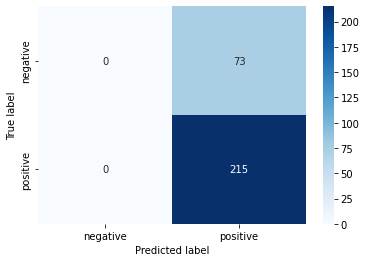

In [26]:
plot_matrix(y_test, y_pred)

In [27]:
pred_result = false_cases(X_test, y_test, y_pred)
pred_result

,sentence,label,prediction
2,sedih banget sebulan jualan telur ayam tipis banget untungnya harga pasaran anjlok semoga berita,0,1
4,harga telur jatuh ternak ayam ditangkap kejam bengis rezim jokowi dikit ngamuk,0,1
10,maghrib berburu telur harga telur kg kedepan telur telur telur,0,1
12,harga pakan meroket telur ambruk peternak garut terpaksa lelang ayam,0,1
14,cantikkk harga mesti cantikkk wallet cantikkk kosong telur ayam,0,1
...,...,...,...
263,pasar sederhana harga beras medium rpkg gula pasir rpkg daging ayam ras rpkg daging sapi rpkg telur ayam ras rpkg cabai merah keriting rpkg bawang putih kating rpkg,0,1
273,harga telur ayam anjlok ribu kilogram radar banyumas,0,1
275,tindakan diambil harga telur ayam meningkat kartel memanipulasi peringkat rantaian nanta linggi,0,1
277,harga telor turun banget plis ayah ambil dijual toko what the fuck seperempat ribu ratus what the fuck kobisa turun segitu,0,1


#### BiLSTM

In [28]:
y_pred = blstm.predict(test_seq, verbose=0)
y_pred = np.argmax(y_pred, axis=1)

In [29]:
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

    negative       0.68      0.74      0.71        73
    positive       0.91      0.88      0.89       215

    accuracy                           0.84       288
   macro avg       0.79      0.81      0.80       288
weighted avg       0.85      0.84      0.85       288



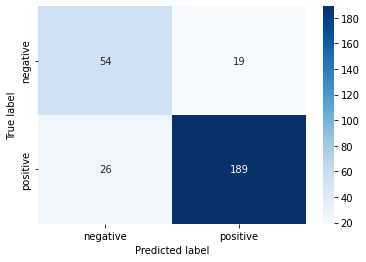

In [30]:
plot_matrix(y_test, y_pred)

In [31]:
pred_result = false_cases(X_test, y_test, y_pred)
pred_result

,sentence,label,prediction
2,sedih banget sebulan jualan telur ayam tipis banget untungnya harga pasaran anjlok semoga berita,0,1
3,tv kmrin harga telor anjlok perusahaan ayam petelor,1,0
7,turun harga telur daging keberhasilan pemerintah memakmurkan rakyat,1,0
10,maghrib berburu telur harga telur kg kedepan telur telur telur,0,1
17,topang harga kemendag serap telur perternak bansos,1,0
33,nasi kuning namribu nasi kuning pakai telor sepuluribu harga telor bandung patribu itb,0,1
35,peternak ayam blitar keluhkan harga telur terjun bebas,0,1
45,harga daging ayam harga telur jatuh chicken eggs nasib peternaknya,1,0
60,kurangnya permintaan pasar telur ayam cabai memengaruhi penjualan sebulan harga merosot drastis rdy,1,0
68,langkah cerdas pemerintah upayakan menyerap telur peternak diperuntukkan bantuan sosial bansos pemerintah masyarakat terdampak pandemi covid upaya memperbaiki harga telur anjlok,1,0


## Imbalanced Dataset

### Check Data Distribution

In [32]:
label_dist = {}
for col in y_train.unique():
  label_dist[col] = y_train[y_train == col].count()
label_dist

{1: 1936, 0: 655}

### Resampling Data

In [33]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

#### Undersampling

In [34]:
rus = RandomUnderSampler(random_state=0)
rus.fit(train_seq, y_train)
X_under_seq, y_under = rus.fit_resample(train_seq, y_train)

In [35]:
label_dist_under = {}
for col in y_under.unique():
  label_dist_under[col] = y_under[y_under == col].count()
label_dist_under

{0: 655, 1: 655}

In [36]:
y_under_seq = to_categorical(y_under, num_classes = 3)

In [37]:
blstm = Sequential()
blstm.add(Embedding(voc, 50, input_length=200))
blstm.add(Bidirectional(LSTM(10, return_sequences=True)))
blstm.add(Bidirectional(LSTM(5)))
blstm.add(Dropout(0.2))
blstm.add(Dense(5))
blstm.add(Dense(3, activation="softmax"))
blstm.summary()
blstm.compile('rmsprop','mse')

blstm.fit(X_under_seq, y_under_seq, epochs=10, batch_size=50, shuffle=False)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 200, 50)           339300    
                                                                 
 bidirectional_2 (Bidirectio  (None, 200, 20)          4880      
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 10)               1040      
 nal)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 10)                0         
                                                                 
 dense_9 (Dense)             (None, 5)                 55        
                                                                 
 dense_10 (Dense)            (None, 3)                

In [38]:
y_pred = blstm.predict(test_seq, verbose=0)
y_pred = np.argmax(y_pred, axis=1)

In [39]:
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

    negative       0.75      0.33      0.46        73
    positive       0.81      0.96      0.88       215

    accuracy                           0.80       288
   macro avg       0.78      0.65      0.67       288
weighted avg       0.79      0.80      0.77       288



#### Oversampling

In [40]:
ros = RandomOverSampler(random_state=0)
ros.fit(train_seq, y_train)
X_over, y_over = ros.fit_resample(train_seq, y_train)

In [41]:
label_dist_over = {}
for col in y_over.unique():
  label_dist_over[col] = y_over[y_over == col].count()
label_dist_over

{1: 1936, 0: 1936}

### Back Translation

In [42]:
# df = pd.DataFrame(list(zip(X_train, y_train)), columns=["tweet", "sentimen"])

In [43]:
# num_pos_needed = label_dist[0] - label_dist[1]
# df_pos = df[df['sentimen'] == 1][:num_pos_needed]
# df_pos

In [44]:
# def preprocess_data(path_to_data):
#   data = pd.read_csv(path_to_data, sep="\t", names=["sentence", 'label'])
#   data = data.replace(to_replace='@[\w\d_]+', regex=True, value='')
#   data = data.replace(to_replace='[http|https]:\\[\w\d_?=#-]+', regex=True, value='')
#   data = data.replace(to_replace='#[\w\d]+', regex=True, value='')
#   data['sentence'] = data['sentence'].astype('str')
#   data['sentence'] = data.apply(lambda x: demoji.replace_with_desc(x['sentence'], sep=""), axis=1)
  
#   with open('data/slang.json','r') as file:
#     slang_dict=json.loads(file.read())['CONTRACTION_MAP']
#   data['sentence'] = data.apply(lambda x: convert_slang(x['sentence'], slang_dict), axis=1)
  
#   data = data.replace(to_replace='[^a-zA-Z ]+', regex=True, value='')
#   data['sentence'] = data['sentence'].str.lower()

#   stopwords = set(nltk.corpus.stopwords.words('english'))
#   data['sentence'] = data.apply(lambda x: remove_stopwords(x['sentence'], stopwords), axis=1)

#   lemmatizer = WordNetLemmatizer()
#   data['sentence'] = data.apply(lambda x: lemmatize(x['sentence'], lemmatizer), axis=1)
  
#   data['label'] = data['label'].astype('category').cat.codes

#   return data

In [45]:
# balanced_data = preprocess_data("/content/drive/MyDrive/Colab Notebooks/Datasets/Sentiment-Analysis-Other-1/data/dbsa/balanced.tsv")
# balanced_data.head()

In [46]:
# X_train_balanced = balanced_data['sentence']
# y_train_balanced = balanced_data['label']
# train_balanced_seq = vectorizer(X_train_balanced)
# y_balanced_seq = to_categorical(y_train_balanced, num_classes = 3)

In [47]:
# blstm = Sequential()
# blstm.add(Embedding(voc, 50, input_length=200))
# blstm.add(Bidirectional(LSTM(10, return_sequences=True)))
# blstm.add(Bidirectional(LSTM(5)))
# blstm.add(Dropout(0.2))
# blstm.add(Dense(5))
# blstm.add(Dense(3, activation="softmax"))
# blstm.summary()
# blstm.compile('rmsprop','mse')

# blstm.fit(train_balanced_seq, y_balanced_seq, epochs=10, batch_size=50, shuffle=False)

In [48]:
# y_pred = blstm.predict(test_seq, verbose=0)
# y_pred = np.argmax(y_pred, axis=1)

In [49]:
# print(classification_report(y_test, y_pred, target_names=target_names))

## Pretrained Word Embedding

In [50]:
path_to_glove_file = "/media/DATA/Notebooks/Datasets/Sentiment Analysis/pretrained_embedding/wikipedia/glove.6B.50d.txt"

vocab_data = []
embedding_matrix = [[0]*50, [0]*50]

with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        vocab_data.append(word)
        embedding_matrix.append(coefs)

In [51]:
vectorizer = TextVectorization(output_sequence_length=200, vocabulary=vocab_data)
voc = vectorizer.get_vocabulary()
num_tokens = len(voc)
embedding_dim = 50

In [52]:
X_train

2763                                                                                                             guis  harga  telor  ayam  dom  kg  domku
2024                                                                                                                                 barang  telur  harga
1057                                                                     buntut  harga  telur  anjlok  harga  jagung  peternak  gugat  mentan  rp  miliar
2133    diitung  makan  pakai  pakan  ayam  namanya  dedak  sekilo  berubah  ayam  betina  harga  telor  ayam  kampung  nelor  bareng  ekor  butir  butir
2436                                                       semar  wl  yuuuk  gaez  akun  ramaikan  daftar  harga  telor  ayam  terjun  bebas  telor  ayam
                                                                              ...                                                                        
1563                                                                        

In [53]:
train_emb_seq = vectorizer(np.asarray(X_train))
test_emb_seq = vectorizer(X_test)

In [54]:
blstm_emb = Sequential()
blstm_emb.add(Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(np.array(embedding_matrix)),
    trainable=False,
))
blstm_emb.add(Bidirectional(LSTM(10, return_sequences=True)))
blstm_emb.add(Bidirectional(LSTM(5)))
blstm_emb.add(Dropout(0.2))
blstm_emb.add(Dense(5))
blstm_emb.add(Dense(3, activation="softmax"))
blstm_emb.summary()
blstm_emb.compile('rmsprop','mse')

blstm_emb.fit(train_emb_seq, y_seq, epochs=10, batch_size=50, shuffle=False)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, None, 50)          20000100  
                                                                 
 bidirectional_4 (Bidirectio  (None, None, 20)         4880      
 nal)                                                            
                                                                 
 bidirectional_5 (Bidirectio  (None, 10)               1040      
 nal)                                                            
                                                                 
 dropout_5 (Dropout)         (None, 10)                0         
                                                                 
 dense_11 (Dense)            (None, 5)                 55        
                                                                 
 dense_12 (Dense)            (None, 3)                

In [55]:
y_pred = blstm_emb.predict(test_emb_seq, verbose=0)
y_pred = np.argmax(y_pred, axis=1)

In [56]:
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

    negative       0.64      0.25      0.36        73
    positive       0.79      0.95      0.86       215

    accuracy                           0.77       288
   macro avg       0.72      0.60      0.61       288
weighted avg       0.75      0.77      0.73       288

